# Monte Carlo Tree Search (MCTS)

In [5]:
import math
import random

class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = []
        self.visits = 0
        self.wins = 0

    def add_child(self, child_state):
        child = Node(child_state, self)
        self.children.append(child)
        return child

    def update(self, result):
        self.visits += 1
        self.wins += result

    def fully_expanded(self):
        return len(self.children) == len(self.state.possible_moves())

    def best_child(self, c_param=1.4):
        choices_weights = [
            (child.wins / child.visits) + c_param * math.sqrt((2 * math.log(self.visits) / child.visits))
            for child in self.children
        ]
        return self.children[choices_weights.index(max(choices_weights))]

class MCTS:
    def __init__(self, iterations=1000):
        self.iterations = iterations

    def search(self, initial_state):
        root = Node(initial_state)

        for _ in range(self.iterations):
            node = self._select(root)
            if not node.fully_expanded():
                node = self._expand(node)
            result = self._simulate(node)
            self._backpropagate(node, result)

        return root.best_child(c_param=0)

    def _select(self, node):
        while node.fully_expanded() and node.children:
            node = node.best_child()
        return node

    def _expand(self, node):
        tried_states = [child.state for child in node.children]
        new_state = random.choice([move for move in node.state.possible_moves() if move not in tried_states])
        return node.add_child(new_state)

    def _simulate(self, node):
        current_state = node.state
        while not current_state.is_terminal():
            current_state = random.choice(current_state.possible_moves())
        return current_state.result()

    def _backpropagate(self, node, result):
        while node is not None:
            node.update(result)
            node = node.parent

class SimpleGameState:
    def __init__(self, moves_left):
        self.moves_left = moves_left

    def possible_moves(self):
        return [SimpleGameState(self.moves_left - 1) for _ in range(self.moves_left)]

    def is_terminal(self):
        return self.moves_left == 0

    def result(self):
        return 1 if self.moves_left % 2 == 0 else 0

# Example usage
initial_state = SimpleGameState(10)
mcts = MCTS(iterations=1000)
best_move = mcts.search(initial_state)
print(best_move.wins)
print(best_move.visits)
print(best_move.children.__len__())
print(f"Best move has {best_move.state.moves_left} moves left.")

100
100
9
Best move has 9 moves left.


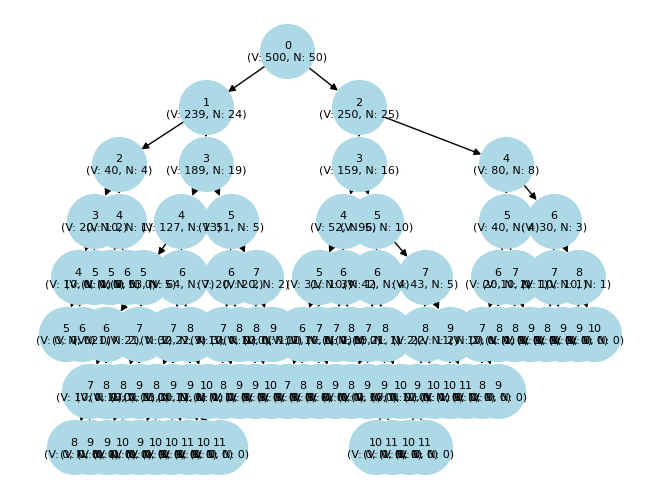

Best path:
State: 2, Value: 250, Visits: 25
State: 4, Value: 80, Visits: 8
State: 5, Value: 40, Visits: 4
State: 6, Value: 20, Visits: 2
State: 7, Value: 10, Visits: 1
State: 8, Value: 0, Visits: 0


: 

In [6]:
import math
import random
import matplotlib.pyplot as plt
import networkx as nx

class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = []
        self.visits = 0
        self.value = 0

    def is_fully_expanded(self):
        return len(self.children) == len(self.state.get_legal_actions())

    def best_child(self, exploration_weight=1.0):
        return max(
            self.children,
            key=lambda child: child.value / (child.visits + 1e-6) + exploration_weight * math.sqrt(
                math.log(self.visits + 1) / (child.visits + 1e-6)
            ),
        )

class State:
    def __init__(self, value):
        self.value = value

    def get_legal_actions(self):
        # Example: You can move to state `value + 1` or `value + 2`.
        return [1, 2]

    def perform_action(self, action):
        return State(self.value + action)

    def is_terminal(self):
        # Example: Terminal state when value >= 10.
        return self.value >= 10

    def get_reward(self):
        # Example: Reward is the state's value.
        return self.value

def mcts(initial_state, itermax):
    root = Node(initial_state)
    G = nx.DiGraph()
    G.add_node(id(root), label=f"{root.state.value}\n(V: {root.value}, N: {root.visits})")

    for _ in range(itermax):
        node = root
        state = initial_state

        # Selection
        while not node.state.is_terminal() and node.is_fully_expanded():
            node = node.best_child()
            state = state.perform_action(node.state.value - state.value)

        # Expansion
        if not node.state.is_terminal():
            for action in state.get_legal_actions():
                next_state = state.perform_action(action)
                child_node = Node(next_state, parent=node)
                node.children.append(child_node)
                G.add_edge(id(node), id(child_node))
                G.add_node(id(child_node), label=f"{next_state.value}\n(V: {child_node.value}, N: {child_node.visits})")

        # Simulation
        reward = 0
        while not state.is_terminal():
            action = random.choice(state.get_legal_actions())
            state = state.perform_action(action)
            reward = state.get_reward()

        # Backpropagation
        while node is not None:
            node.visits += 1
            node.value += reward
            G.nodes[id(node)]["label"] = f"{node.state.value}\n(V: {node.value}, N: {node.visits})"
            node = node.parent

    return root, G

def draw_tree(graph):
    from networkx.drawing.nx_agraph import graphviz_layout
    pos = graphviz_layout(graph, prog="dot")
    labels = nx.get_node_attributes(graph, "label")
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1500, node_color="lightblue", font_size=8)
    plt.show()

# Run MCTS
initial_state = State(0)
iterations = 50
root, graph = mcts(initial_state, iterations)

# Visualize the search tree
draw_tree(graph)

# Print the best path
best_node = root.best_child(exploration_weight=0)
print("Best path:")
while best_node is not None:
    print(f"State: {best_node.state.value}, Value: {best_node.value}, Visits: {best_node.visits}")
    if not best_node.children:
        break
    best_node = best_node.best_child(exploration_weight=0)
